In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.signal import savgol_filter
from helper import get_all_csv_files_path, calculate_statistics, calculate_all_feature_product
from generate_adaptive_boundaries_optimization import run_ga, calculate_features_for_boundaries
from find_correct_clusters_and_do_ks_test import elbow_method, generate_train_test_indices, plot_kde_train_test, perform_ks_test
import shap
import seaborn as sns
import os


In [16]:
data_folder = '../Data/'
filename = data_folder + 'spring24_solvtemp_jpm.csv'
df = pd.read_csv(filename)


Data Splitting

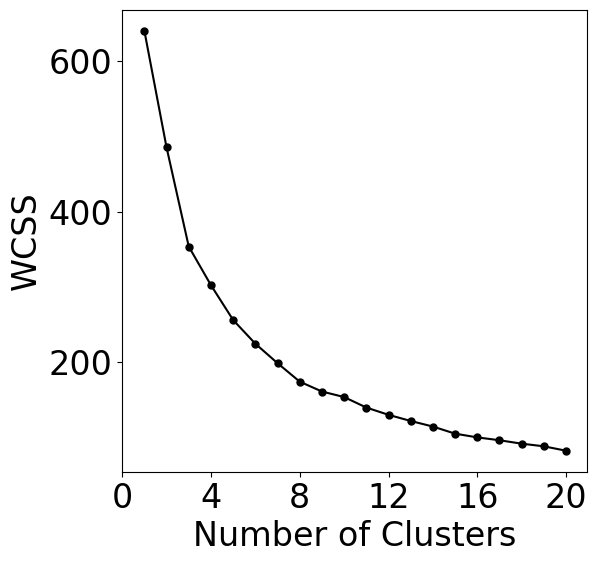

[  1   2   4   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  38  39  40  41  43
  44  46  47  48  49  51  52  53  54  56  57  58  59  60  61  62  65  66
  67  68  69  70  71  73  74  76  77  78  79  81  82  83  85  86  88  90
  91  93  94  95  96  97  98  99 100 101 103 104 106 107 108 109 110 111
 112 114 115 116 117 119 120 121 122 123 125 126 127]
[102  45  92  63  50  89  72  87  84  75  37  55  13 118  42  64  80  17
 113  36   0   3   9 124 105]


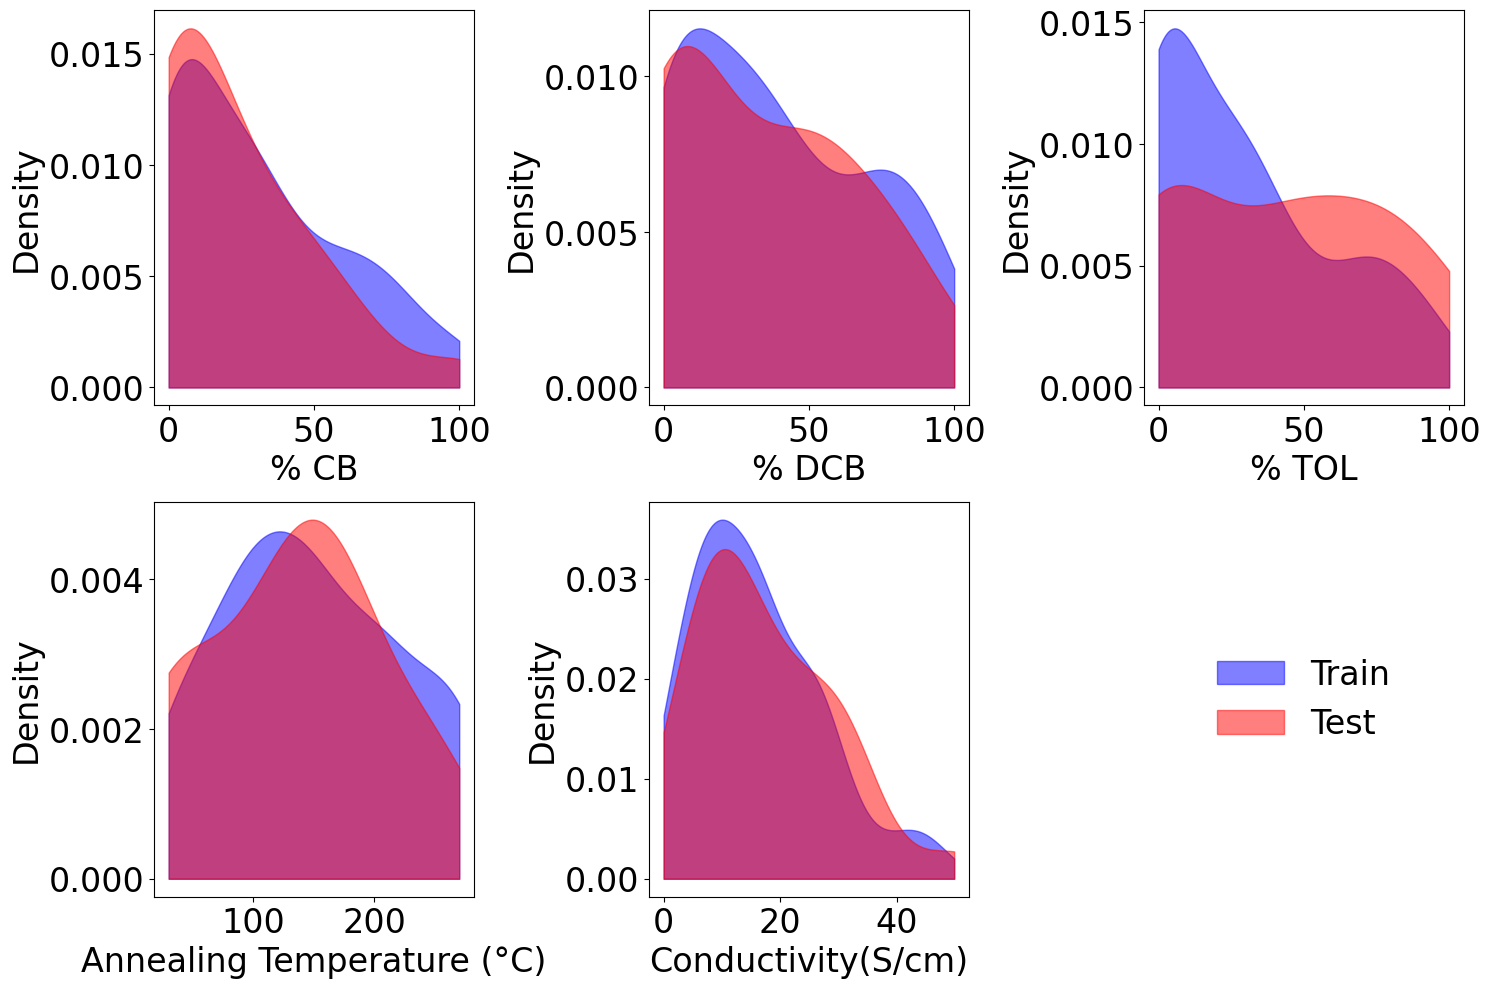

{'CB': {'KS Statistic': 0.13514563106796115, 'p-value': 0.7989845490897471}, 'DCB': {'KS Statistic': 0.13553398058252428, 'p-value': 0.79571351846174}, 'TOL': {'KS Statistic': 0.2504854368932039, 'p-value': 0.13154767893351016}, 'annealing_temperature': {'KS Statistic': 0.14097087378640777, 'p-value': 0.7619480330165909}, 'conductivity': {'KS Statistic': 0.12271844660194174, 'p-value': 0.8803575679145628}}


In [17]:
normalized_df = elbow_method(df)
num_clusters = 5 # Set this based on elbow method results
train_indices, test_indices = generate_train_test_indices(num_clusters, normalized_df)
print(train_indices)
print(test_indices)
plot_kde_train_test(train_indices, test_indices, df)
ks_results = perform_ks_test(train_indices, test_indices, df)
print(ks_results)

**Expert Model**

Model 4 - E-QSPR 

Input - Expert Defined Features

Output - Conductivity

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Train R^2: 0.9839, Test R^2: 0.8003
Train RMSE: 1.40, Test RMSE: 5.16
Train MAE: 1.14, Test MAE: 3.81
Kendall Tau Train: 0.9207, Test: 0.7533
Pearson Correlation Train: 0.9937, Test: 0.9413


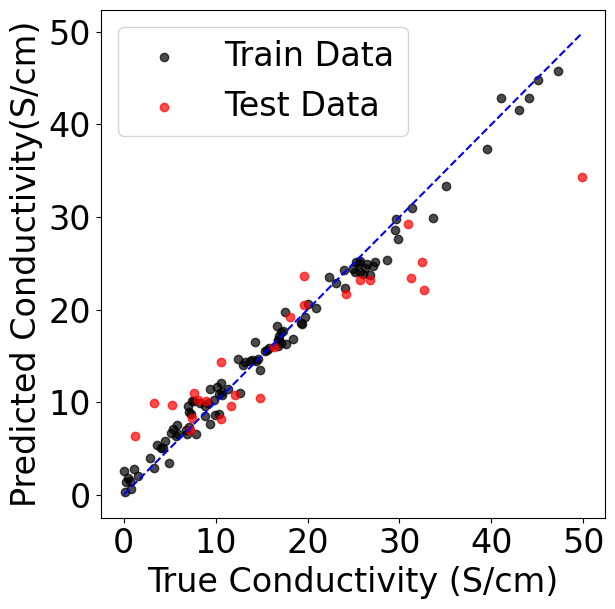

In [18]:
input_columns = ['E 00',	'E 01',	'E 02',	'00/01',	'Relative Anion Signal',	'Bleaching %',	'polaron ratio']
input_data = df[input_columns].values
output_data = df[['conductivity']].values
lower_limit = np.array([0, 0, 0, 30])
upper_limit = np.array([100, 100, 100, 270])
X_train = input_data[train_indices]
y_train = output_data[train_indices]
X_test = input_data[test_indices]
y_test = output_data[test_indices]


model_4 = GradientBoostingRegressor(loss ='squared_error', learning_rate=0.1, n_estimators=100, min_samples_leaf=1, random_state=42)
 
y_pred_train, y_pred_test, _, _, _, _, _, _,_, _,_,_ = calculate_statistics(model_4, X_train, y_train, X_test, y_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred_train, color='black', alpha=0.7, label='Train Data')
plt.scatter(y_test, y_pred_test, color='red', alpha=0.7, label='Test Data')
plt.plot([min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    [min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    color='blue', linestyle='--')
plt.xlabel('True Conductivity (S/cm)', fontsize=24)
plt.ylabel('Predicted Conductivity(S/cm)', fontsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()


**Data-Driven Models**

In [21]:
n_preanneal_boundaries=5
preanneal_boundaries_limit = [300, 900]
n_postanneal_boundaries=5
postanneal_boundaries_limit = [300, 900]
n_postdope_boundaries=5
postdope_boundaries_limit = [300, 2450]

In [ ]:
measurement_type = 'Postanneal'
mode = "train"
spectra_axis = 'energy'  # 'energy' or 'wavelength'
on_second_order = True
if measurement_type == 'Preanneal':
    n_boundaries = n_preanneal_boundaries
    boundaries_limit = preanneal_boundaries_limit
elif measurement_type == 'Postanneal':
    n_boundaries = n_postanneal_boundaries
    boundaries_limit = postanneal_boundaries_limit
elif measurement_type == 'Postdope':
    n_boundaries = n_postdope_boundaries
    boundaries_limit = postdope_boundaries_limit

if spectra_axis == 'energy':
    boundaries_limit = [1239.8 / boundary for boundary in boundaries_limit]
    boundaries_limit = boundaries_limit[::-1] 

measurement_csv_files_train, measurement_csv_files_test = get_all_csv_files_path(data_folder, measurement_type, train_indices, test_indices)

if mode == "train":
    measurement_files = measurement_csv_files_train
else:
    measurement_files = measurement_csv_files_test

Genetic Algorithm

In [ ]:
loss_progress = []
order = 2
optimal_boundaries, result, loss_progress = run_ga(measurement_files, df, boundaries_limit, 
                                                   n_boundaries, spectra_axis,  order, 
                                                   n = 100,  ngen=100)

In [23]:

optimal_boundaries= [1.3776, 1.8284, 1.9825, 2.0952, 2.7003]  # Identified using GA on Postanneal Spectra Data


Model 1 - I-QSPR 1

Input - Spectra Features + Processing Conditions

Output -  Conductivity

Train R^2: 0.8884, Test R^2: 0.7656
Train RMSE: 3.68, Test RMSE: 5.59
Train MAE: 2.52, Test MAE: 4.17
Kendall Tau Train: 0.8331, Test: 0.7533
Pearson Correlation Train: 0.9549, Test: 0.9008


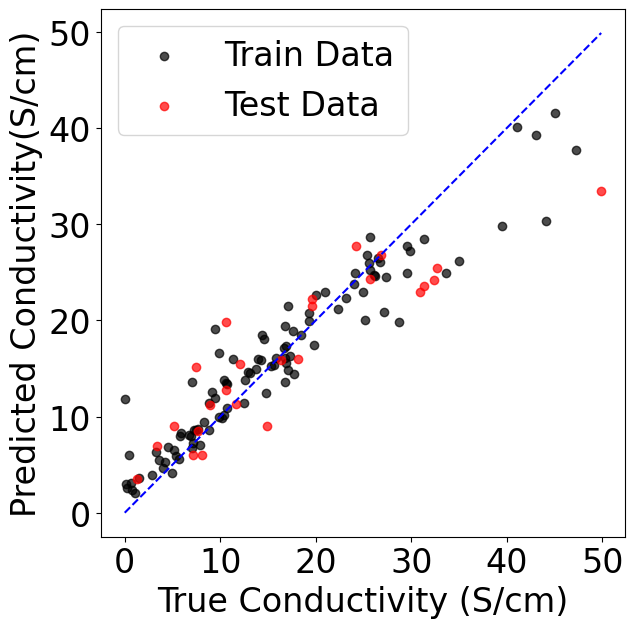

In [24]:
measurement_csv_files_train, measurement_csv_files_test = get_all_csv_files_path(data_folder, measurement_type, train_indices, test_indices)

# train
df_measurement_features_train_orignal = calculate_features_for_boundaries(optimal_boundaries, measurement_csv_files_train, spectra_axis='energy',  order=0)
feature_names = []
for i in range(len(optimal_boundaries) - 1):
    feature_name = f"AUC_{i+1}"
    feature_names.append(feature_name)
df_measurement_features_train_orignal.columns = ['exp_id'] + feature_names
df_measurement_features_train_derivative = calculate_features_for_boundaries(optimal_boundaries, measurement_csv_files_train, spectra_axis='energy',  order=2)
feature_names_derivative = []
for i in range(len(optimal_boundaries) - 1):
    feature_name = f"d\u00B2AUC_{i+1}"
    feature_names_derivative.append(feature_name)
df_measurement_features_train_derivative.columns = ['exp_id'] + feature_names_derivative
df_measurement_features_train = pd.merge(df_measurement_features_train_orignal, df_measurement_features_train_derivative, on='exp_id', how='inner')
df_measurement_features_train = pd.merge(df_measurement_features_train, df[['exp_id', 'CB', 'DCB', 'TOL', 'annealing_temperature', 'conductivity']], on='exp_id', how='inner')


#test
df_measurement_features_test_orignal = calculate_features_for_boundaries( optimal_boundaries, measurement_csv_files_test, spectra_axis='energy',  order=0)
df_measurement_features_test_orignal.columns = ['exp_id'] + feature_names
df_measurement_features_test_derivative = calculate_features_for_boundaries( optimal_boundaries, measurement_csv_files_test, spectra_axis='energy',  order=2)
df_measurement_features_test_derivative.columns = ['exp_id'] + feature_names_derivative
df_measurement_features_test = pd.merge(df_measurement_features_test_orignal, df_measurement_features_test_derivative, on='exp_id', how='inner')
df_measurement_features_test = pd.merge(df_measurement_features_test, df[['exp_id', 'CB', 'DCB', 'TOL', 'annealing_temperature', 'conductivity']], on='exp_id', how='inner')



X_train = df_measurement_features_train.drop(columns=['exp_id', 'conductivity'])  # All columns except exp_id and conductivity
y_train = df_measurement_features_train['conductivity'].values

X_test = df_measurement_features_test.drop(columns=['exp_id', 'conductivity'])
y_test = df_measurement_features_test['conductivity'].values

model_1 = RandomForestRegressor(n_estimators=70, criterion = "squared_error",  min_samples_split=5, random_state=42)


y_pred_train, y_pred_test, _, _, _, _, _, _,_, _,_,_ = calculate_statistics(model_1, X_train, y_train, X_test, y_test)

plt.figure(figsize=(6.2, 6.2))
plt.scatter(y_train, y_pred_train, color='black', alpha=0.7, label='Train Data')
plt.scatter(y_test, y_pred_test, color='red', alpha=0.7, label='Test Data')
plt.plot([min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    [min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    color='blue', linestyle='--')
plt.xlabel('True Conductivity (S/cm)', fontsize=24)
plt.ylabel('Predicted Conductivity(S/cm)', fontsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

Model 2 - I-QSPR 2

Input - Spectra Features + Processing Conditions + Product of Spectra Features

Output -  Conductivity

Train R^2: 0.9255, Test R^2: 0.7652
Train RMSE: 3.00, Test RMSE: 5.59
Train MAE: 2.12, Test MAE: 4.09
Kendall Tau Train: 0.8632, Test: 0.7467
Pearson Correlation Train: 0.9723, Test: 0.9120


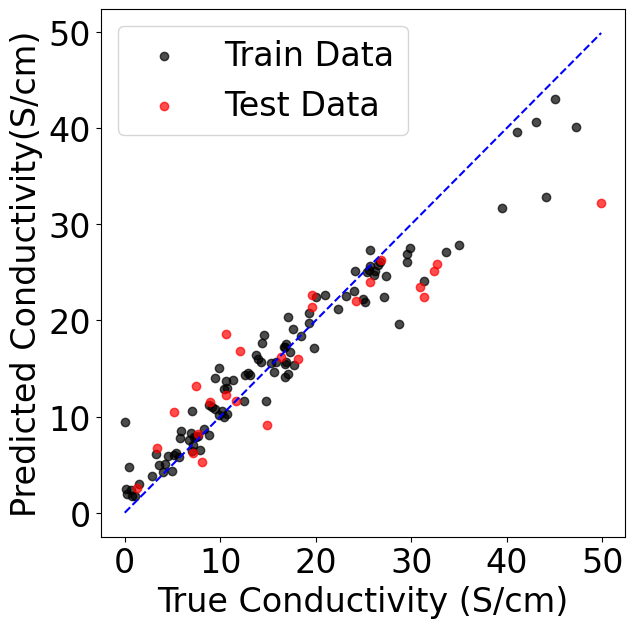

In [25]:
measurement_csv_files_train, measurement_csv_files_test = get_all_csv_files_path(data_folder, measurement_type, train_indices, test_indices)

# Train Data
df_measurement_features_train_orignal = calculate_features_for_boundaries(optimal_boundaries, measurement_csv_files_train, spectra_axis='energy',  order=0)
feature_names = []
for i in range(len(optimal_boundaries) - 1):
    feature_name = f"AUC_{i+1}"
    feature_names.append(feature_name)
df_measurement_features_train_orignal.columns = ['exp_id'] + feature_names
df_measurement_features_train_derivative = calculate_features_for_boundaries(optimal_boundaries, measurement_csv_files_train, spectra_axis='energy',  order=2)
feature_names_derivative = []
for i in range(len(optimal_boundaries) - 1):
    feature_name = f"d\u00B2AUC_{i+1}"
    feature_names_derivative.append(feature_name)
df_measurement_features_train_derivative.columns = ['exp_id'] + feature_names_derivative
df_measurement_features_train = pd.merge(df_measurement_features_train_orignal, df_measurement_features_train_derivative, on='exp_id', how='inner')
df_measurement_features_train_ratio = calculate_all_feature_product(df_measurement_features_train)
df_measurement_features_train = pd.merge(df_measurement_features_train, df_measurement_features_train_ratio, on='exp_id', how='inner')
df_measurement_features_train = pd.merge(df_measurement_features_train, df[['exp_id', 'CB', 'DCB', 'TOL', 'annealing_temperature', 'conductivity']], on='exp_id', how='inner')

df_measurement_features_test_orignal = calculate_features_for_boundaries( optimal_boundaries, measurement_csv_files_test, spectra_axis='energy',  order=0)
df_measurement_features_test_orignal.columns = ['exp_id'] + feature_names
df_measurement_features_test_derivative = calculate_features_for_boundaries( optimal_boundaries, measurement_csv_files_test, spectra_axis='energy',  order=2)
df_measurement_features_test_derivative.columns = ['exp_id'] + feature_names_derivative
df_measurement_features_test = pd.merge(df_measurement_features_test_orignal, df_measurement_features_test_derivative, on='exp_id', how='inner')
df_measurement_features_test_ratio = calculate_all_feature_product(df_measurement_features_test)
df_measurement_features_test = pd.merge(df_measurement_features_test, df_measurement_features_test_ratio, on='exp_id', how='inner')
df_measurement_features_test = pd.merge(df_measurement_features_test, df[['exp_id', 'CB', 'DCB', 'TOL', 'annealing_temperature',  'conductivity']], on='exp_id', how='inner')

X_train = df_measurement_features_train.drop(columns=['exp_id', 'conductivity'])  
y_train = df_measurement_features_train['conductivity'].values

X_test = df_measurement_features_test.drop(columns=['exp_id', 'conductivity'])
y_test = df_measurement_features_test['conductivity'].values

model_2 = RandomForestRegressor(n_estimators=50, criterion = "squared_error",  min_samples_split=2,  random_state=42)
y_pred_train, y_pred_test, _, _, _, _, _, _,_, _,_,_ = calculate_statistics(model_2, X_train, y_train, X_test, y_test)


plt.figure(figsize=(6.2, 6.2))
plt.scatter(y_train, y_pred_train, color='black', alpha=0.7, label='Train Data')
plt.scatter(y_test, y_pred_test, color='red', alpha=0.7, label='Test Data')
plt.plot([min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    [min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    color='blue', linestyle='--')
plt.xlabel('True Conductivity (S/cm)', fontsize=24)
plt.ylabel('Predicted Conductivity(S/cm)', fontsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()






Using SHAPLEY for Feature Ranking and Forward Selection

Model 3 - I-QSPR 3

Input - Best Features From Spectra Features + Processing Conditions + Product of Subset Features

Output -  Conductivity

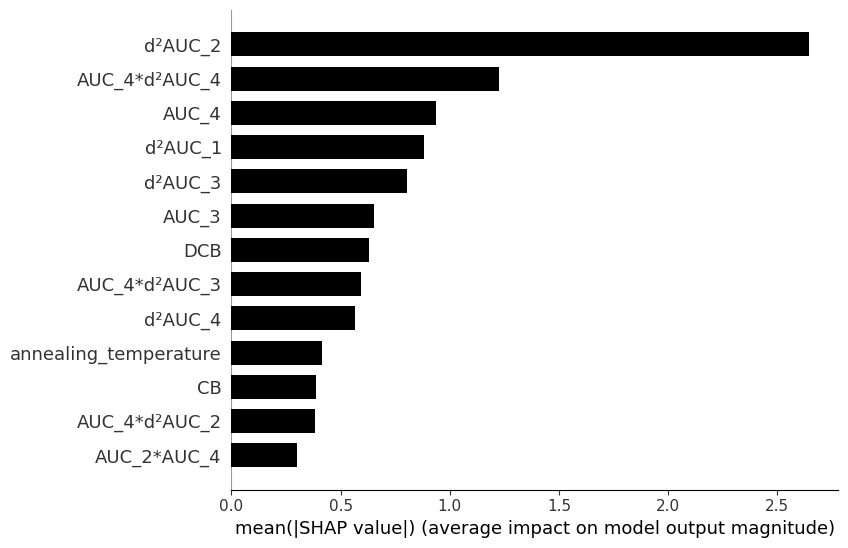

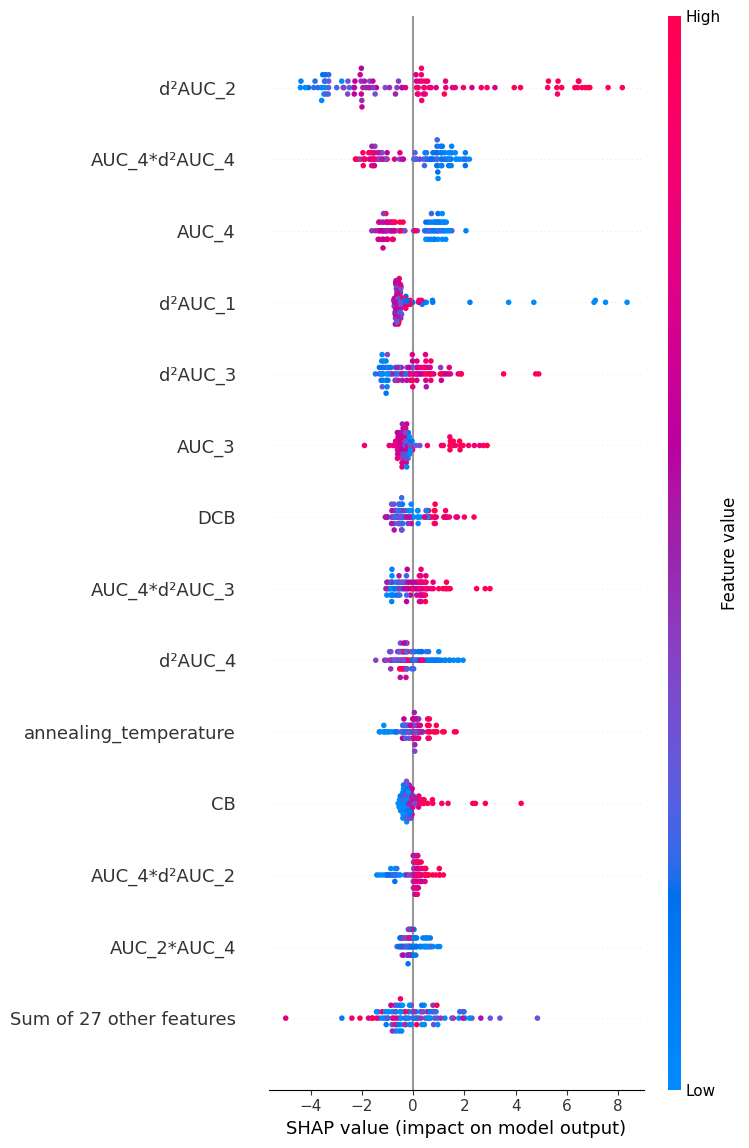

Using top 1 SHAP features: ['d²AUC_2']
Train R^2: 0.6778, Test R^2: 0.1879
Train RMSE: 6.25, Test RMSE: 10.40
Train MAE: 4.63, Test MAE: 7.88
Kendall Tau Train: 0.6621, Test: 0.2838
Pearson Correlation Train: 0.8248, Test: 0.4780
-------------------------------------------------------------
Using top 2 SHAP features: ['d²AUC_2', 'AUC_4*d²AUC_4']
Train R^2: 0.8722, Test R^2: 0.5329
Train RMSE: 3.93, Test RMSE: 7.89
Train MAE: 2.82, Test MAE: 6.33
Kendall Tau Train: 0.7997, Test: 0.4800
Pearson Correlation Train: 0.9412, Test: 0.7335
-------------------------------------------------------------
Using top 3 SHAP features: ['d²AUC_2', 'AUC_4*d²AUC_4', 'AUC_4']
Train R^2: 0.9044, Test R^2: 0.5693
Train RMSE: 3.40, Test RMSE: 7.57
Train MAE: 2.42, Test MAE: 5.80
Kendall Tau Train: 0.8350, Test: 0.5933
Pearson Correlation Train: 0.9591, Test: 0.7696
-------------------------------------------------------------
Using top 4 SHAP features: ['d²AUC_2', 'AUC_4*d²AUC_4', 'AUC_4', 'd²AUC_1']
Train R

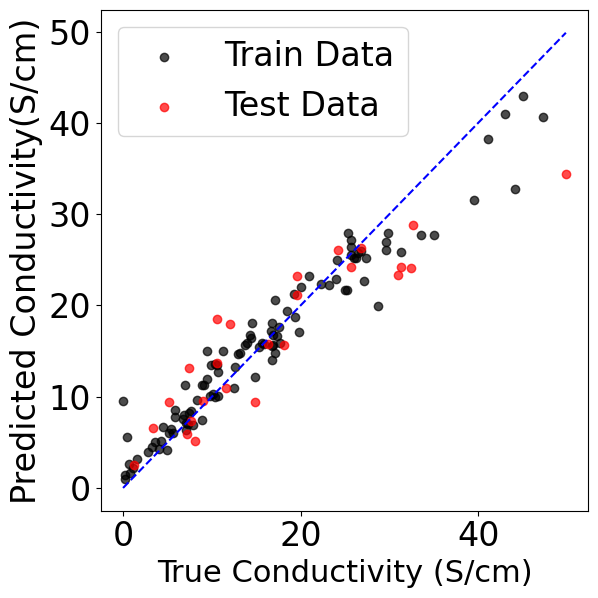

-------------------------------------------------------------
Using top 14 SHAP features: ['d²AUC_2', 'AUC_4*d²AUC_4', 'AUC_4', 'd²AUC_1', 'd²AUC_3', 'AUC_3', 'DCB', 'AUC_4*d²AUC_3', 'd²AUC_4', 'annealing_temperature', 'CB', 'AUC_4*d²AUC_2', 'AUC_2*AUC_4', 'TOL']
Train R^2: 0.9264, Test R^2: 0.7718
Train RMSE: 2.99, Test RMSE: 5.51
Train MAE: 2.13, Test MAE: 3.96
Kendall Tau Train: 0.8632, Test: 0.7533
Pearson Correlation Train: 0.9721, Test: 0.9077
-------------------------------------------------------------
Using top 15 SHAP features: ['d²AUC_2', 'AUC_4*d²AUC_4', 'AUC_4', 'd²AUC_1', 'd²AUC_3', 'AUC_3', 'DCB', 'AUC_4*d²AUC_3', 'd²AUC_4', 'annealing_temperature', 'CB', 'AUC_4*d²AUC_2', 'AUC_2*AUC_4', 'TOL', 'AUC_3*AUC_4']
Train R^2: 0.9275, Test R^2: 0.7730
Train RMSE: 2.96, Test RMSE: 5.50
Train MAE: 2.15, Test MAE: 4.07
Kendall Tau Train: 0.8545, Test: 0.7200
Pearson Correlation Train: 0.9719, Test: 0.9043
-------------------------------------------------------------
Using top 16 SH

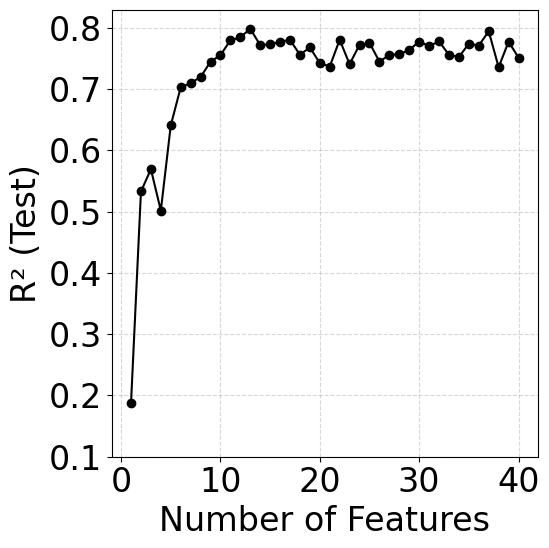

In [26]:
explainer = shap.Explainer(model_2, X_train)
shap_values = explainer(X_train)
# Summary plot
plt.rcParams.update({
    'font.size': 24,
    'axes.labelsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 24,
    'figure.titlesize': 24
})

shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=13, color='k', plot_size=(9,6), show=False)
plt.show()
plt.close()


shap.plots.beeswarm(shap_values, max_display=14, show = False, plot_size=(8,12))
plt.tight_layout()
plt.show()
plt.close()

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_feature_importance = list(zip(X_test.columns, mean_abs_shap))
shap_feature_importance = sorted(shap_feature_importance, key=lambda x: x[1], reverse=True)
shap_ranked_features = [f[0] for f in shap_feature_importance]

# Forward Selection Method
r2_scores_shap = []
num_features_shap = []

for i in range(1, len(shap_ranked_features) + 1):
    selected_features = shap_ranked_features[:i]
    print(f"Using top {i} SHAP features: {selected_features}")
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    y_pred_train, y_pred_test, _, r2_test, _, _, _, _, _, _, _, _ = calculate_statistics(
        model_2, X_train_subset, y_train, X_test_subset, y_test
    )
    r2_scores_shap.append(r2_test)
    num_features_shap.append(i)
    if i == 13:  # Max R2 at 13 features
        plt.figure(figsize=(6.5, 6.5))
        plt.scatter(y_train, y_pred_train, color='black', alpha=0.7, label='Train Data')
        plt.scatter(y_test, y_pred_test, color='red', alpha=0.7, label='Test Data')
        plt.plot([min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
            [min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
            color='blue', linestyle='--')
        plt.xlabel('True Conductivity (S/cm)', fontsize=22)
        plt.ylabel('Predicted Conductivity(S/cm)', fontsize=24)
        plt.legend(fontsize=24)
        plt.tight_layout()
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.show()

    print("-------------------------------------------------------------")

# Plot R² vs. number of SHAP-ranked features
plt.figure(figsize=(6, 6))
plt.plot(num_features_shap, r2_scores_shap, marker='o', color='k')
plt.ylabel('R² (Test)', fontsize=24)
plt.xlabel('Number of Features', fontsize=24)
plt.xticks([0, 10, 20,  30,  40], fontsize=24)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=24)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



**Combined Model**

Using SHAPLEY for Feature Ranking and Forward Selection

Use Best Data Driven Features and Expert Features

Model 5 - QSPR 

Input - Best Features From Spectra Features + Processing Conditions + Product of Subset Features

Output -  Conductivity

In [28]:
data_driven_features = ['d²AUC_2', 'AUC_4*d²AUC_4', 'AUC_4', 'd²AUC_1', 'd²AUC_3', 'AUC_3', 'DCB', 'AUC_4*d²AUC_3', 'd²AUC_4', 'annealing_temperature', 'CB', 'AUC_4*d²AUC_2', 'AUC_2*AUC_4']  # Top 13 features from SHAP analysis
expert_features = ['E 00',	'E 01',	'E 02',	'00/01',	'Relative Anion Signal',	'Bleaching %',	'polaron ratio'] # 7 expert features


Combine model with both features and do shap based feature selection

Train R^2: 0.9914, Test R^2: 0.8311
Train RMSE: 1.02, Test RMSE: 4.74
Train MAE: 0.72, Test MAE: 3.45
Kendall Tau Train: 0.9466, Test: 0.7533
Pearson Correlation Train: 0.9966, Test: 0.9354


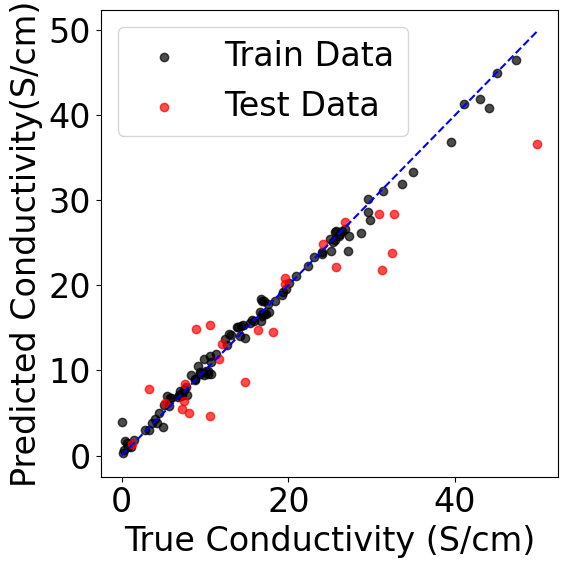

In [29]:
measurement_csv_files_train, measurement_csv_files_test = get_all_csv_files_path(data_folder, measurement_type, train_indices, test_indices)
df_measurement_features_train_orignal = calculate_features_for_boundaries(optimal_boundaries, measurement_csv_files_train, spectra_axis='energy',  order=0)
feature_names = []
for i in range(len(optimal_boundaries) - 1):
    feature_name = f"AUC_{i+1}"
    feature_names.append(feature_name)
df_measurement_features_train_orignal.columns = ['exp_id'] + feature_names
df_measurement_features_train_derivative = calculate_features_for_boundaries(optimal_boundaries, measurement_csv_files_train, spectra_axis='energy',  order=2)
feature_names_derivative = []
for i in range(len(optimal_boundaries) - 1):
    feature_name = f"d\u00B2AUC_{i+1}"
    feature_names_derivative.append(feature_name)
df_measurement_features_train_derivative.columns = ['exp_id'] + feature_names_derivative
df_measurement_features_train = pd.merge(df_measurement_features_train_orignal, df_measurement_features_train_derivative, on='exp_id', how='inner')
df_measurement_features_train_ratio = calculate_all_feature_product(df_measurement_features_train)
df_measurement_features_train = pd.merge(df_measurement_features_train, df_measurement_features_train_ratio, on='exp_id', how='inner')
df_measurement_features_train = pd.merge(df_measurement_features_train, df[['exp_id', 'CB', 'DCB', 'TOL', 'annealing_temperature', 'E 00',	'E 01',	'E 02',	'00/01',	'Relative Anion Signal',	'Bleaching %',	'polaron ratio','conductivity']], on='exp_id', how='inner')
df_measurement_features_train = df_measurement_features_train[data_driven_features + expert_features + ['exp_id', 'conductivity']]


df_measurement_features_test_orignal = calculate_features_for_boundaries( optimal_boundaries, measurement_csv_files_test, spectra_axis='energy',  order=0)
df_measurement_features_test_orignal.columns = ['exp_id'] + feature_names
df_measurement_features_test_derivative = calculate_features_for_boundaries( optimal_boundaries, measurement_csv_files_test, spectra_axis='energy',  order=2)
df_measurement_features_test_derivative.columns = ['exp_id'] + feature_names_derivative
df_measurement_features_test = pd.merge(df_measurement_features_test_orignal, df_measurement_features_test_derivative, on='exp_id', how='inner')
df_measurement_features_test_ratio = calculate_all_feature_product(df_measurement_features_test)
df_measurement_features_test = pd.merge(df_measurement_features_test, df_measurement_features_test_ratio, on='exp_id', how='inner')
df_measurement_features_test = pd.merge(df_measurement_features_test, df[['exp_id', 'CB', 'DCB', 'TOL', 'annealing_temperature', 'E 00', 'E 01',	'E 02',	'00/01',	'Relative Anion Signal',	'Bleaching %',	'polaron ratio', 'conductivity']], on='exp_id', how='inner')
df_measurement_features_test = df_measurement_features_test[data_driven_features + expert_features + ['exp_id', 'conductivity']]

X_train = df_measurement_features_train.drop(columns=['exp_id', 'conductivity'])  
y_train = df_measurement_features_train['conductivity'].values

X_test = df_measurement_features_test.drop(columns=['exp_id', 'conductivity'])
y_test = df_measurement_features_test['conductivity'].values

model_5 = GradientBoostingRegressor(loss ='squared_error', learning_rate=0.1, n_estimators=150, min_samples_leaf=5, random_state=42)
y_pred_train, y_pred_test, _, _, _, _, _, _,_, _,_,_ = calculate_statistics(model_5, X_train, y_train, X_test, y_test)
plt.figure(figsize=(6.2, 6.2))
plt.scatter(y_train, y_pred_train, color='black', alpha=0.7, label='Train Data')
plt.scatter(y_test, y_pred_test, color='red', alpha=0.7, label='Test Data')
plt.plot([min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    [min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
    color='blue', linestyle='--')
plt.xlabel('True Conductivity (S/cm)', fontsize=24)
plt.ylabel('Predicted Conductivity(S/cm)', fontsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()


SHAPLEY Feature Selection for QSPR 5

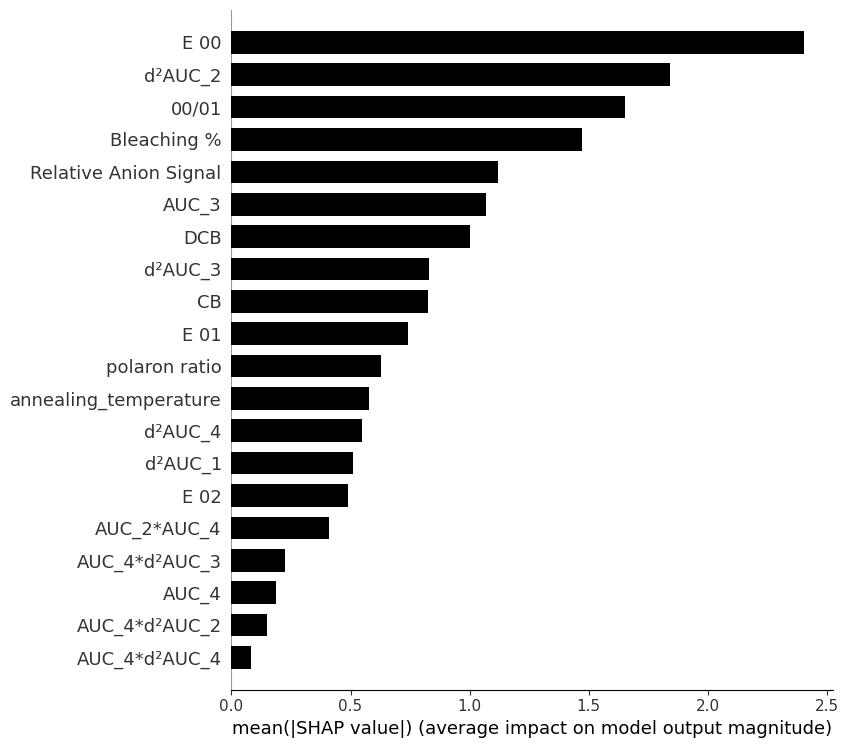

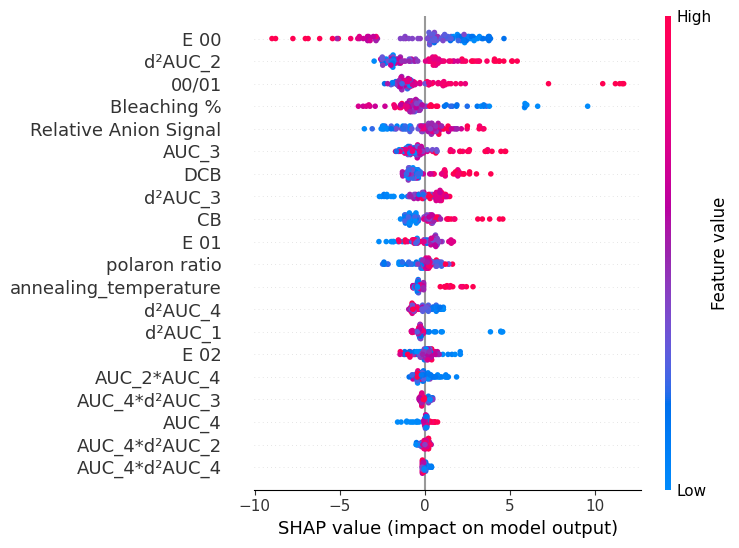

Using top 1 SHAP features: ['E 00']
Train R^2: 0.7827, Test R^2: 0.3899
Train RMSE: 5.13, Test RMSE: 9.01
Train MAE: 3.64, Test MAE: 6.16
Kendall Tau Train: 0.7143, Test: 0.5357
Pearson Correlation Train: 0.8937, Test: 0.6280
-------------------------------------------------------------
Using top 2 SHAP features: ['E 00', 'd²AUC_2']
Train R^2: 0.8665, Test R^2: 0.5907
Train RMSE: 4.02, Test RMSE: 7.38
Train MAE: 2.91, Test MAE: 5.27
Kendall Tau Train: 0.7933, Test: 0.6177
Pearson Correlation Train: 0.9377, Test: 0.7769
-------------------------------------------------------------
Using top 3 SHAP features: ['E 00', 'd²AUC_2', '00/01']
Train R^2: 0.9294, Test R^2: 0.6676
Train RMSE: 2.92, Test RMSE: 6.65
Train MAE: 2.12, Test MAE: 5.17
Kendall Tau Train: 0.8457, Test: 0.6267
Pearson Correlation Train: 0.9677, Test: 0.8415
-------------------------------------------------------------
Using top 4 SHAP features: ['E 00', 'd²AUC_2', '00/01', 'Bleaching %']
Train R^2: 0.9385, Test R^2: 0.670

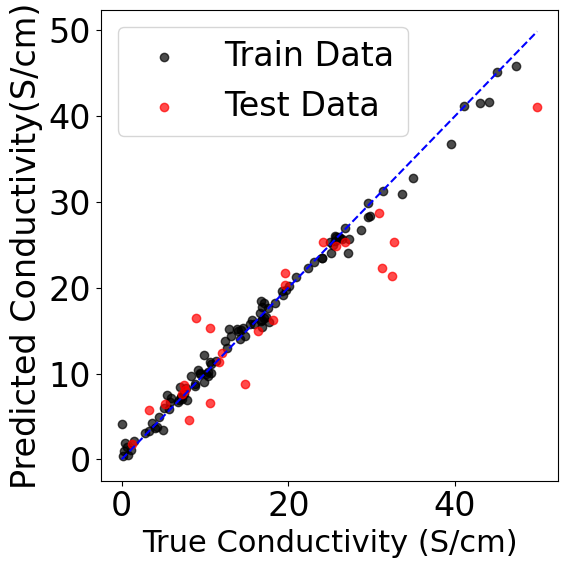

-------------------------------------------------------------
Using top 16 SHAP features: ['E 00', 'd²AUC_2', '00/01', 'Bleaching %', 'Relative Anion Signal', 'AUC_3', 'DCB', 'd²AUC_3', 'CB', 'E 01', 'polaron ratio', 'annealing_temperature', 'd²AUC_4', 'd²AUC_1', 'E 02', 'AUC_2*AUC_4']
Train R^2: 0.9922, Test R^2: 0.8355
Train RMSE: 0.97, Test RMSE: 4.68
Train MAE: 0.72, Test MAE: 3.42
Kendall Tau Train: 0.9386, Test: 0.7667
Pearson Correlation Train: 0.9968, Test: 0.9378
-------------------------------------------------------------
Using top 17 SHAP features: ['E 00', 'd²AUC_2', '00/01', 'Bleaching %', 'Relative Anion Signal', 'AUC_3', 'DCB', 'd²AUC_3', 'CB', 'E 01', 'polaron ratio', 'annealing_temperature', 'd²AUC_4', 'd²AUC_1', 'E 02', 'AUC_2*AUC_4', 'AUC_4*d²AUC_3']
Train R^2: 0.9932, Test R^2: 0.8270
Train RMSE: 0.91, Test RMSE: 4.80
Train MAE: 0.67, Test MAE: 3.40
Kendall Tau Train: 0.9451, Test: 0.7600
Pearson Correlation Train: 0.9973, Test: 0.9325
-----------------------------

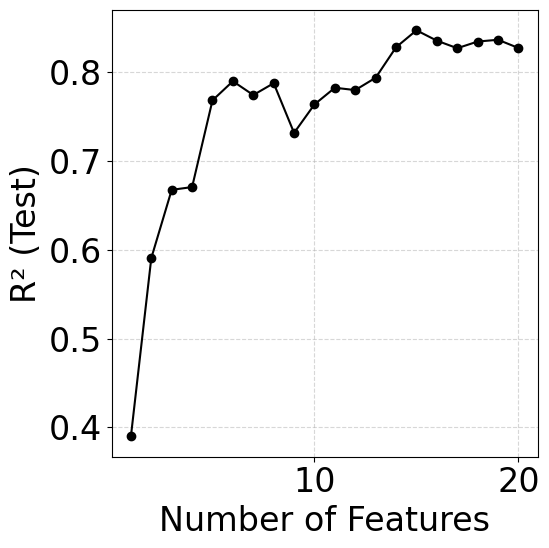

In [30]:
explainer = shap.Explainer(model_5, X_train)
shap_values = explainer(X_train)
# Summary plot
plt.rcParams.update({
    'font.size': 24,
    'axes.labelsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 24,
    'figure.titlesize': 24
})

shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, color='k', plot_size=(9,8), show=False)
plt.show()
plt.close()

shap.plots.beeswarm(shap_values, max_display=20, show = False, plot_size=(8,6))
plt.tight_layout()
plt.show()
plt.close()

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_feature_importance = list(zip(X_test.columns, mean_abs_shap))
shap_feature_importance = sorted(shap_feature_importance, key=lambda x: x[1], reverse=True)
shap_ranked_features = [f[0] for f in shap_feature_importance]

r2_scores_shap = []
num_features_shap = []

for i in range(1, len(shap_ranked_features) + 1):
    selected_features = shap_ranked_features[:i]
    print(f"Using top {i} SHAP features: {selected_features}")
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    y_pred_train, y_pred_test, _, r2_test, _, _, _, _, _, _, _, _ = calculate_statistics(
        model_5, X_train_subset, y_train, X_test_subset, y_test
    )
    
    r2_scores_shap.append(r2_test)
    num_features_shap.append(i)

    if i == 15: # Max R2 at 15 features
        plt.figure(figsize=(6.2, 6.2))
        plt.scatter(y_train, y_pred_train, color='black', alpha=0.7, label='Train Data')
        plt.scatter(y_test, y_pred_test, color='red', alpha=0.7, label='Test Data')
        plt.plot([min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
            [min(np.concatenate((y_train, y_test))), max(np.concatenate((y_train, y_test)))],
            color='blue', linestyle='--')
        plt.xlabel('True Conductivity (S/cm)', fontsize=22)
        plt.ylabel('Predicted Conductivity(S/cm)', fontsize=24)
        plt.legend(fontsize=24)
        plt.tight_layout()
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.show()
    print("-------------------------------------------------------------")

#Plot R² vs. number of SHAP-ranked features
plt.figure(figsize=(6, 6))
plt.plot(num_features_shap, r2_scores_shap, marker='o', color='k')
plt.ylabel('R² (Test)', fontsize=24)
plt.xlabel('Number of Features', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


